# La ruta más corta para visitar los pueblos mágicos de México

## Introducción al problema

Unos de los problemas más antiguos y sencillos relacionados con la optimización es el Problema del Vendedor Ambulante, el cual implica encontrar la ruta más corta que nos permita visitar un número n de ciudades, volviendo al finalizar el recorrido al punto de partida inicial. Evidentemente, a medida que crece el valor de n, se incrementa el número de posibles soluciones y, por lo tanto, también lo hace la complejidad del problema. En la figura se muestra un esquema del problema para n=3 y n=15. Para tres ciudades, la distancia es la misma sin importar el orden, con lo cual cualquier ruta brinda la mejor solución posible, sin embargo, al incrementar el número de ciudades a 15, deja de ser claro cómo el orden en que son visitadas afecta la calidad de nuestra solución. 

<img src= "https://raw.githubusercontent.com/LuisVelasc/Imagenes/main/RutaMasCortaPueblosMagicos1.PNG" alt="drawing" width="350">

Buscando crear un ejemplo que el lector pueda identificar en la realidad, se decidió optimizar en este capítulo la ruta que nos permita visitar los 132 Pueblos Mágicos de México que a la fecha de febrero del 2021 se encuentran inscritos en el programa dirigido por la Secretaria de Turismo[1]. El programa de los pueblos mágicos está orientado a alentar a los turistas, tanto nacionales como extranjeros, a visitar los pueblos que presentan el mayor legado cultural en nuestro país, y ha obtenido tan buen recibimiento que incluso países como España[2] han implementado programas similares en sus territorios. 

En este caso, el problema se resolverá por medio del algoritmo conocido como Ant Colony Optimization. Esta metaheurística fue presentada por Doringo et al[3] en el año de 1991. La genialidad de este algoritmo se encuentra en la idea de simular el comportamiento de una colonia de hormigas empleando un conjunto de objetos computacionales simples, capaces de comunicarse entre sí por medio de “feromonas”. 

Para comprender el funcionamiento de este algoritmo, es necesario describir el proceso natural al cual es análogo. En la naturaleza, las hormigas no son capaces de realizar tareas complicadas cuando se encuentran solas, sin embargo, es sabido que al juntar un número elevado de éstas se comienza a conformar una “inteligencia” colectiva que les permite resolver problemas complejos como el localizar alimento o el identificar la ruta más corta a su hormiguero. Buena parte de esta inteligencia colectiva se encuentra sostenida por la comunicación entre los individuos de la colonia, misma que se desarrolla a través de sustancias químicas llamadas feromonas. En el algoritmo de Ant Colony se utiliza elementos como la visivilidad y la cantidad de feromonas dejadas por otras hormigas para generar una ruta optimizada. Esto se muestra de manera esquematica en la siguiente figura. 

<img src= "https://raw.githubusercontent.com/LuisVelasc/Imagenes/main/RutaMasCortaPueblosMagicos2.PNG" alt="drawing" width="300">

En la figura se observa a una hormiga que tiene que escoger a cuál pueblo dirigirse (A, B o C). Debido a su lejanía, solo una hormiga ha decidido moverse en dirección a B. Por otra parte, A se encuentra más cerca, pero muchas hormigas se están moviendo hacia C, con lo cual, estos dos pueblos tienen altas probabilidades de ser escogidos como destino de la hormiga en O.

## Pueblos Mágicos de México

En la siguiente figura se muestra la ubicación de los 132 Pueblos Mágicos que actualmente se encuentran inscritos en el programa, para facilitar el cálculo de las distancias que los separan, sus posiciones dentro del territorio nacional se encuentran referenciadas en coordenadas geográficas. Obsérvese que en la península de Baja California se encuentran ubicados tres Pueblos Mágicos. 

<img src= "https://raw.githubusercontent.com/LuisVelasc/Imagenes/main/RutaMasCortaPueblosMagicos3.PNG" alt="drawing" width="350">

## Variables del código

A continuación se definen los factores que definen el desempeño del algoritmo.

In [1]:
alfa=2.0; % Coef. intensidad
beta=2.5; % Coef. distancia
ro=0.95; % Coef. evaporación
Q=10^5; % Feromonas
a=4; % Hormigas por pueblo
tao=0.1; % Intensidad inicial
CiclosTotales=25; % Iteraciones a realizar
R=6367.5; % Radio estimado de la Tierra
cRestr=1; % 1=Sí, 0=No

Se carga el archivo con las coordenadas geográficas de los Pueblos Mágicos de México. Por simplicidad, se omiten los tres pueblos ubicados en la península de Baja California.

In [2]:
X=load('C:\Users\fable\OneDrive\Desktop\Académico\LibroMH\2_ACO\Codigos\PueblosMagicos.txt');
X=transpose(X);

Se definen dos listas para evitar que el algoritmo rutas que consideren "cruzar por el mar" entre los pueblos de Yucatán y el resto.

In [3]:
CRest=[8,43,45,55,96,116,118,17,22,42,72,73,83,101];
CY=[8,43,45,55,96,116,118];

Se definen matrices y algunas variables que almacenarán los resultados intermedios del algoritmo. 

In [4]:
n=size(X,2); % N de pueblos
m=a*n; % N de hormigas totales

% Matrices de ceros
D=zeros(n,n); % De distancia
Nu=zeros(n,n); % De visibilidad
P=zeros(n,n); % De probabilidad
L=zeros(m,n); % De longitudes
MResultados=zeros(m,n); % De resultados

% Se define las matrices de intensidad
T=tao*ones(n,n);
DT=zeros(n,n);

% Mejores resultados
MejorL=10^9;
MejorRuta=zeros(1,n);

Se define la matriz donde se almacenan las distancias entre los pueblos considerados.

In [5]:
for i=1 : n
    for j=1 : n
        D(i,j)=2*R*asin(((sind((X(1,j)-X(1,i))/2))^2+cosd(X(1,i))*cosd(X(1,j))*(sind((X(2,j)-X(2,i))/2))^2)^(1/2));
        
        if cRestr==1
            % Se entra a Yucatán
            if size(find(j==CY),2)~=0
                if size(find(i==CRest),2)==0
                    D(i,j)=1000*D(i,j);
                end
            end
            
            % Se sale de Yucatán
            if size(find(i==CY),2)~=0
                if size(find(j==CRest),2)==0
                    D(i,j)=1000*D(i,j);
                end
            end
            
        end
        
    end
end

Se define la matriz de visibilidad entre pueblos, solo es el recíproco de la distancia.

In [6]:
for i=1 : n
    for j=1 : n
        if i==j
            Nu(i,j)=0;
        else
            Nu(i,j)=1/D(i,j);
        end
    end
end

Se definen la matriz de probabilidad de transición entre un pueblo y otro. Las "hormigas" usarán estas probabilidades para ir generando su ruta, un pueblo a la vez. 

In [7]:
for i=1 : n
    for j=1 : n
        P(i,j)=(T(i,j)^alfa)*(Nu(i,j)^beta)/(dot(T(i,:).^alfa,Nu(i,:).^beta));
    end
end

Para evitar que las hormigas visiten un pueblo más de una vez, se crea una matriz que restringe los movimiento de las hormigas en función de los pueblos que han visitado.

In [8]:
b=diag(ones(1,n));
Tabu = b;
for i=1 : a-1
    Tabu=[Tabu;b];
end

## Aplicación de Ant Colony Optimization

Se aplica el algoritmo, actualización de feromonas por ciclo.

In [9]:
for Ciclo=1 : CiclosTotales
    for i=1 : m
        Cont=1; % Contador para almacenar resultados
        d=find(1==Tabu(i,:),1); % Localiza pueblo inicial i de la hormiga
        MResultados(i,Cont)=d; % Se inicia ruta
        
        for j=1 : n
            % Se obtiene lista de posibles movimientos
            if j==n
            U=Tabu(i,:);
            U(1,MResultados(i,1))=0;
            else
                U=Tabu(i,:);
            end
            
            % Se cambian valores (1=0) y (0=1)
            U(U==0)=2;
            U(U==1)=0;
            U(U==2)=1;
            
            % Se descartan las probabilidades de los no movimientos permitidos
            V=U.*(P(d,:));
            
            % Se crean los intervalos de probabilidad que definen qué movimiento
            % realizar
            for k=1 : n
                W(1,k)=sum(V(1,[1:k]));
            end
            
            % Se normaliza la probabilidad hasta 1
            W=W./W(1,n);
            
            % c es el pueblo de salida
            c=d;
            
            % d es el pueblo destino
            d=find(rand<W,1);
            
            % Se obliga a obtener un valor de d
            if size(d,2)==0
                while size(d,2)==0
                    d=find(rand<W,1);
                end
            end
            
            % Se actualiza la matriz de movimientos permitidos
            Tabu(i,d)=1;
            
            % Se actualiza matriz de distancia y resultados
            Cont=Cont+1;
            L(i,Cont)=D(c,d);
            MResultados(i,Cont)=d;
        end
        
        % Se determina distancia total recorrida por la hormiga
        L(i,1)=sum(L(i,[2:n+1]));
                
    end % Se ha completado una iteración
    
    % Se guardar los mejores resultados de la iteración
    if min(L(:,1))<MejorL
        MejorL= min(L(:,1));
        MejorRuta=MResultados(find(L(:,1)==MejorL),:);
        figure(1)
        comet(X(2,MejorRuta(1,:)),X(1,MejorRuta(1,:)),0.05)
    end
    
    min(L(:,1))
    % Se actualizan las feromonas generadas en esta iteración
    for i=1 : m
        for j=1 : n-1
            pinicial=MResultados(i,j);
            pfinal=MResultados(i,j+1);
            
            DT(pinicial,pfinal)=DT(pinicial,pfinal)+Q/L(i,1);
            T(pinicial,pfinal)=ro*T(pinicial,pfinal)+DT(pinicial,pfinal);
        end
    end
    
    % Se actualiza la matriz de probabilidad
    for i=1 : n
        for j=1 : n
            P(i,j)=(T(i,j)^alfa)*(Nu(i,j)^beta)/(dot(T(i,:).^alfa,Nu(i,:).^beta));
        end
    end

    % Se limpia la matriz de ciudades
    b=diag(ones(1,n));
    Tabu = b;
    for i=1 : a-1
        Tabu=[Tabu;b];
    end
end


ans =

   2.0342e+04


ans =

   1.2667e+04


ans =

   1.2630e+04


ans =

   1.2655e+04


ans =

   1.2533e+04


ans =

   1.2524e+04


ans =

   1.2486e+04


ans =

   1.2619e+04


ans =

   1.2503e+04


ans =

   1.2311e+04


ans =

   1.2554e+04


ans =

   1.2458e+04


ans =

   1.2331e+04


ans =

   1.2503e+04


ans =

   1.2660e+04


ans =

   1.2389e+04


ans =

   1.2637e+04


ans =

   1.2483e+04


ans =

   1.2534e+04


ans =

   1.2562e+04


ans =

   1.2492e+04


ans =

   1.2503e+04


ans =

   1.2503e+04


ans =

   1.2519e+04


ans =

   1.2458e+04




## Resultados

Se imprime la distancia de la ruta de mayor calidad generada.

In [10]:
% Comprobación de la mejor respuesta
for i=1 : n
    MejorD(1,i)=D(MejorRuta(1,i),MejorRuta(1,i+1));
end
sum(MejorD(1,:))


ans =

   1.2311e+04




Se cargan los nombres de los pueblos para generar una lista con los pueblos ordenados de la ruta de mayor calidad generada.

In [11]:
% Regresar resultado final
Y=importdata('C:\Users\fable\OneDrive\Desktop\Académico\LibroMH\2_ACO\Codigos\ListaPueblos.txt');
for i=1 : n
    CiudadesOrdenadas(1,i)=Y(MejorRuta(1,i),1);
end
CiudadesOrdenadas=transpose(CiudadesOrdenadas);

Se imprime la lista con las ciudades de la mejor ruta.

In [12]:
CiudadesOrdenadas


CiudadesOrdenadas =

  129x1 cell array

    {'21. Comala, Colima'                                                   }
    {'101. Tapalpa, Jalisco'                                                }
    {'2. Ajijic, Jalisco'                                                   }
    {'89. San Pedro Tlaquepaque, Jalisco'                                   }
    {'108. Tequila, Jalisco'                                                }
    {'46. Jala, Nayarit'                                                    }
    {'24. Compostela de Indias, Nayarit'                                    }
    {'96. Sayulita, Nayarit'                                                }
    {'91. San Sebastián del Oeste, Jalisco'                                 }
    {'58. Mascota, Jalisco'                                                 }
    {'100. Talpa de Allende, Jalisco'                                       }
    {'63. Mexcaltitán, Nayarit'                                             }
    {'33. El Rosario, 

Se gráfica la mejor ruta encontrada.


ans =

    'Helvetica'




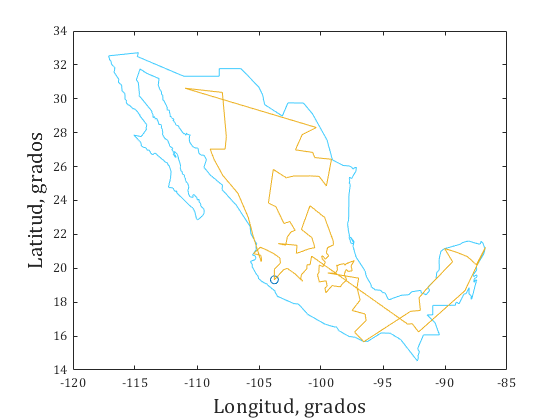

In [13]:
% Se grafica la mejor solución encontrada
Y=load('C:\Users\fable\OneDrive\Desktop\Académico\LibroMH\2_ACO\Codigos\Pais.txt');

figure(1)
plot(Y(:,2),Y(:,1),'color',[0.25 0.8 1])
hold on
comet(X(2,MejorRuta(1,:)),X(1,MejorRuta(1,:)),0.05)

xlabel("Longitud, grados","fontSize",16)
ylabel("Latitud, grados","fontSize",16)
get(gca,'fontname')
set(gca,'fontname','Cambria Math')
hold off

## Referencias

[1] Secretaria de Turismo. Pueblos Mágicos de México. https://www.gob.mx/sectur/articulos/pueblos-magicos-206528 (2021).

[2] Instituto de Desarrollo Local. Pueblos Mágicos de España. https://www.pueblosmagicos.es/ (2021).

[3] Colorni, A., Dorigo, M. & Maniezzo, V. Distributed Optimization by ant colonies. in Proceedings of the First European Conference on Artificial Life (1991).
